In [11]:
##2603376 Knowkedge Discovery and Data Mining
#Final Project
#Data Source: Lending Club Loan Data
#https://www.kaggle.com/erykwalczak/d/wendykan/lending-club-loan-data/initial-loan-book-analysis
#Tanawit Pattanaveerangkoon

In [12]:
rawdata <- read.csv("loan.csv")

In [53]:
library(caret)
library(caTools)
library(dplyr)
library(randomForest)
library(pROC)

In [54]:
nrow(rawdata)

[1] 887379

In [55]:
loan <- rawdata

In [56]:
summary(loan)

       id             member_id          loan_amnt      funded_amnt   
 Min.   :   54734   Min.   :   70473   Min.   :  500   Min.   :  500  
 1st Qu.: 9206643   1st Qu.:10877134   1st Qu.: 8000   1st Qu.: 8000  
 Median :34433267   Median :37095283   Median :13000   Median :13000  
 Mean   :32465133   Mean   :35001825   Mean   :14755   Mean   :14742  
 3rd Qu.:54908135   3rd Qu.:58471347   3rd Qu.:20000   3rd Qu.:20000  
 Max.   :68617057   Max.   :73544841   Max.   :35000   Max.   :35000  
                                                                      
 funded_amnt_inv         term           int_rate      installment     
 Min.   :    0    36 months:621125   Min.   : 5.32   Min.   :  15.67  
 1st Qu.: 8000    60 months:266254   1st Qu.: 9.99   1st Qu.: 260.70  
 Median :13000                       Median :12.99   Median : 382.55  
 Mean   :14702                       Mean   :13.25   Mean   : 436.72  
 3rd Qu.:20000                       3rd Qu.:16.20   3rd Qu.: 572.60  
 Max. 

In [57]:
unique(loan$loan_status)

[1] Fully Paid                                         
 [2] Charged Off                                        
 [3] Current                                            
 [4] Default                                            
 [5] Late (31-120 days)                                 
 [6] In Grace Period                                    
 [7] Late (16-30 days)                                  
 [8] Does not meet the credit policy. Status:Fully Paid 
 [9] Does not meet the credit policy. Status:Charged Off
[10] Issued                                             
10 Levels: Charged Off Current ... Late (31-120 days)

In [58]:
loan$is_bad[loan$loan_status=="Charged Off"] <- 0
loan$is_bad[loan$loan_status=="Default"] <- 0
loan$is_bad[loan$loan_status=="Does not meet the credit policy. Status:Charged Off"] <- 0
loan$is_bad[loan$loan_status=="In Grace Period"] <- 0
loan$is_bad[loan$loan_status=="Default Receiver"] <- 0
loan$is_bad[loan$loan_status=="Late (16-30 days)"] <- 0
loan$is_bad[loan$loan_status=="Late (31-120 days)"] <- 0

loan$is_bad[loan$loan_status=="Fully Paid"] <- 1
loan$is_bad[loan$loan_status=="Current"] <- 1
loan$is_bad[loan$loan_status=="Does not meet the credit policy. Status:Fully Paid"] <- 1
loan$is_bad[loan$loan_status=="Issued"] <- 1

loan <- subset(loan, ! is.na(loan$loan_status))

In [59]:
summary(as.factor(loan$is_bad))

0      1 
 67429 819950

In [60]:
bad <- loan[loan$is_bad == 0, ]
notbad <- loan[loan$is_bad == 1, ]

In [61]:
notbad <- sample_n(notbad, nrow(bad))

In [62]:
nrow(bad)
nrow(notbad)

[1] 67429

[1] 67429

In [63]:
loan <- rbind(bad, notbad)

In [64]:
is.na(loan) <- loan == ""

In [65]:
# Create date variables that R recognizes as dates
loan$issue_d <- as.Date(paste('15', loan$issue_d), format='%d %b-%y')
loan$earliest_cr_line <- as.Date(paste('15', loan$earliest_cr_line), format='%d %b-%y')

In [66]:
# Identify loans that have already come to term
loan$term.months <- NA
loan$term.months[loan$term==" 36 months"] <- 36
loan$term.months[loan$term==" 60 months"] <- 60
# remove the "term" variable because it is redundant with the term.months variable
loan$term <- NULL 

In [67]:
# Convert character percentages to numeric variables
loan$int_rate <- as.numeric(gsub("%" , "", loan$int_rate))
loan$revol_util <- as.numeric(gsub("%" , "", loan$revol_util))

In [68]:
# Convert character employment length to numeric variable
loan$emp_length <- gsub(" years" , "", loan$emp_length)
loan$emp_length <- gsub(" year" , "", loan$emp_length)
loan$emp_length <- ifelse(loan$emp_length == "10+", 10, loan$emp_length)
loan$emp_length <- ifelse(loan$emp_length == "< 1", 0.5, loan$emp_length)
loan$emp_length <- as.numeric(loan$emp_length)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

In [69]:
# Convert character to ordinal variable
loan$grade[loan$grade == ""] <- NA
loan$grade <- ordered(loan$grade)

In [70]:
# Remove variables where more than 20% of the observations are missing values
loan <- loan[, colMeans(is.na(loan)) <= .20]

In [71]:
# Remove factor vars with too many levels
too.many.levels <- function(x) {
    is.factor(x) == TRUE & length(levels(x)) > 32
}
delete <- lapply(loan, too.many.levels)
loan <- loan[, delete == FALSE]
remove(too.many.levels, delete)

In [72]:
# Calculate the percentage of loan paid back
loan$paid.back <- (loan$funded_amnt - loan$out_prncp)/loan$funded_amnt

# Remove missing
loan <- subset(loan, ! is.na(loan$paid.back))

In [73]:
# Remove variables where all values are the same
loan <- loan[sapply(loan, function(x) length(levels(factor(x)))>1)]

In [74]:
nrow(loan)

[1] 134858

In [75]:
#loan <- sample_n(loan, 25000)
#nrow(loan)

In [76]:
loan$loan_status <- NULL
loan$id <- NULL

loan$is_bad <- as.factor(loan$is_bad)
summary(loan$is_bad)

0     1 
67429 67429

In [77]:
set.seed(2017)

indextrain <- sample(2,nrow(loan),replace = T,prob =c(0.8,0.2))

train <- loan[indextrain==1,-1]
test <- loan[indextrain==2,-1]

In [78]:
train$member_id <- NULL
test$member_id <- NULL

In [79]:
summary(train)

   loan_amnt      funded_amnt    funded_amnt_inv    int_rate    
 Min.   :  500   Min.   :  500   Min.   :    0   Min.   : 5.32  
 1st Qu.: 8000   1st Qu.: 8000   1st Qu.: 8000   1st Qu.:11.36  
 Median :13000   Median :13000   Median :13000   Median :14.16  
 Mean   :14780   Mean   :14757   Mean   :14681   Mean   :14.46  
 3rd Qu.:20000   3rd Qu.:20000   3rd Qu.:20000   3rd Qu.:17.57  
 Max.   :35000   Max.   :35000   Max.   :35000   Max.   :28.99  
                                                                
  installment      grade       emp_length      home_ownership 
 Min.   :  15.91   A:12604   Min.   : 0.500   ANY     :    1  
 1st Qu.: 264.73   B:26589   1st Qu.: 2.000   MORTGAGE:51034  
 Median : 387.84   C:30076   Median : 6.000   NONE    :    8  
 Mean   : 441.56   D:20963   Mean   : 5.946   OTHER   :   34  
 3rd Qu.: 575.70   E:11718   3rd Qu.:10.000   OWN     :10364  
 Max.   :1408.13   F: 4701   Max.   :10.000   RENT    :46492  
                   G: 1282   NA's   :56

In [80]:
nrow(train)
nrow(test)


[1] 107933

[1] 26925

In [81]:
rf.model <- randomForest(factor(is_bad) ~ .,data = train, ntree = 150, type="response", importance=TRUE, na.action=na.omit)

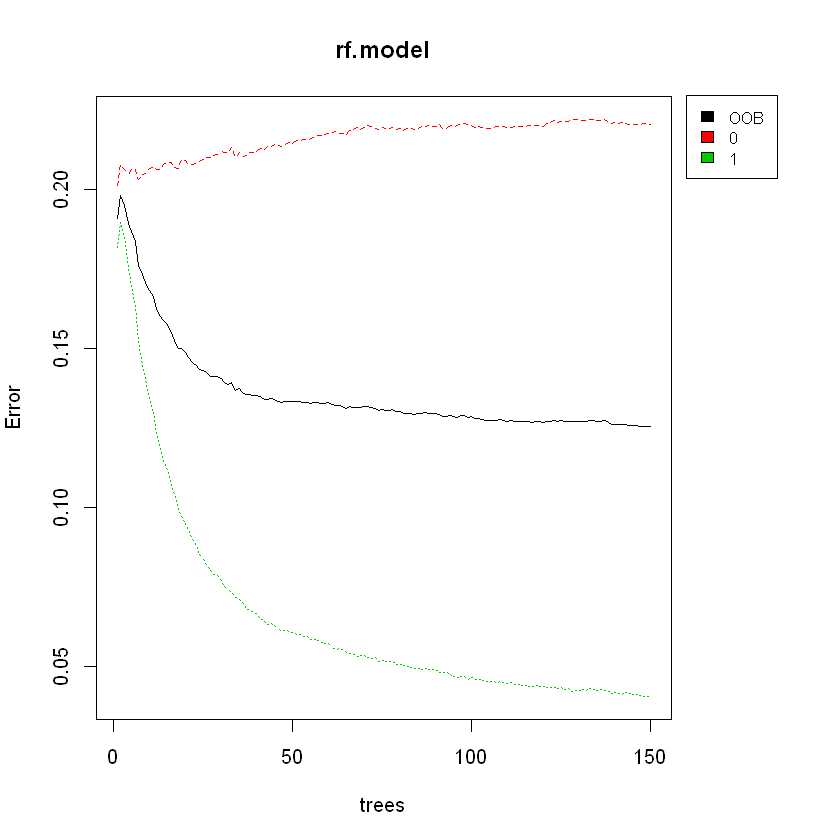

In [82]:
layout(matrix(c(1,2),nrow=1),
       width=c(4,1)) 
par(mar=c(5,4,4,0))
plot(rf.model)
par(mar=c(5,0,4,2))
plot(c(0,1),type="n", axes=F, xlab="", ylab="")
legend("top", colnames(rf.model$err.rate),col=1:4,cex=0.8,fill=1:4)

In [83]:
names(train)

[1] "loan_amnt"                  "funded_amnt"               
 [3] "funded_amnt_inv"            "int_rate"                  
 [5] "installment"                "grade"                     
 [7] "emp_length"                 "home_ownership"            
 [9] "annual_inc"                 "verification_status"       
[11] "issue_d"                    "pymnt_plan"                
[13] "purpose"                    "dti"                       
[15] "delinq_2yrs"                "earliest_cr_line"          
[17] "inq_last_6mths"             "open_acc"                  
[19] "pub_rec"                    "revol_bal"                 
[21] "revol_util"                 "total_acc"                 
[23] "initial_list_status"        "out_prncp"                 
[25] "out_prncp_inv"              "total_pymnt"               
[27] "total_pymnt_inv"            "total_rec_prncp"           
[29] "total_rec_int"              "total_rec_late_fee"        
[31] "recoveries"                 "collection_recovery_fee"   
[33] "last_pymnt_amnt"            "collections_12_mths_ex_med"
[35] "application_type"           "acc_now_delinq"            
[37] "tot_coll_amt"               "tot_cur_bal"               
[39] "total_rev_hi_lim"           "is_bad"                    
[41] "term.months"                "paid.back"

In [84]:
test$predictoutput <- predict(rf.model,test,type="response")
test$is_bad <- as.numeric(as.factor(test$is_bad))
test$predictoutput <- as.numeric(as.factor(test$predictoutput))
test$is_bad_auc <- as.numeric(as.factor(test$is_bad))
test$predictoutput_auc <- as.numeric(as.factor(test$predictoutput))
auc(test$is_bad_auc, test$predictoutput_auc)


Area under the curve: 0.8686

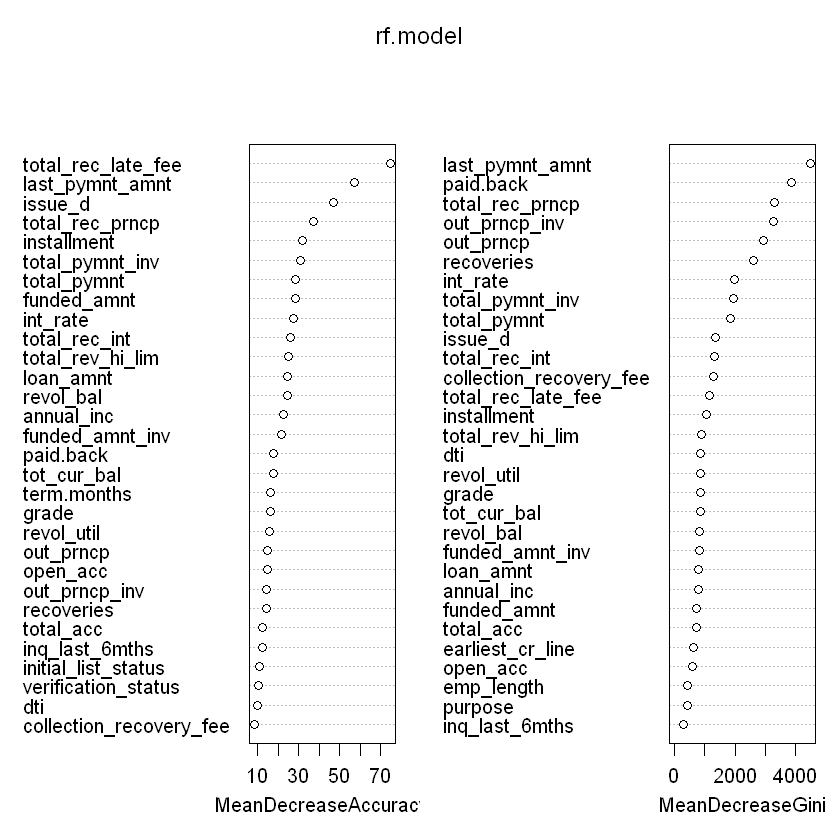

In [85]:
varImpPlot(rf.model)

In [86]:
confusionMatrix(test$predictoutput,test$is_bad)

Confusion Matrix and Statistics

          Reference
Prediction     1     2
         1  8270   428
         2  2417 11277
                                          
               Accuracy : 0.8729          
                 95% CI : (0.8685, 0.8773)
    No Information Rate : 0.5227          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.7433          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7738          
            Specificity : 0.9634          
         Pos Pred Value : 0.9508          
         Neg Pred Value : 0.8235          
             Prevalence : 0.4773          
         Detection Rate : 0.3693          
   Detection Prevalence : 0.3884          
      Balanced Accuracy : 0.8686          
                                          
       'Positive' Class : 1               
                                          

In [87]:
summary(loan$out_prncp_inv)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0    1956    6236   10870   35000 

In [88]:
#logisticregression1 <- glm(is_bad ~ ., data=train, family=binomial())
#summary(logisticregression1)

In [89]:
#test$regressionoutput <- predict(rf.model,test,type="response")

#test$is_bad <- as.numeric(as.factor(test$is_bad))
#test$regressionoutput <- as.numeric(as.factor(test$regressionoutput))

#test$is_bad_auc <- as.numeric(as.factor(test$is_bad))
#test$regressionoutput_auc <- as.numeric(as.factor(test$regressionoutput))

#auc(test$is_bad_auc, test$regressionoutput_auc)

In [90]:
#confusionMatrix(test$is_bad, test$regressionoutput)

In [91]:
#write.csv(loan, file = "loan.csv", row.names=FALSE)